# **ZDT1** Problem

In [1]:
%pip install pymoo --quiet

Note: you may need to restart the kernel to use updated packages.


In [28]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from pymoo.util.plotting import plot
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter
from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

C:\Users\34627\AppData\Local\Temp\ipykernel_16616\1161980849.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(nsga2_f1, nsga2_f2, color="green", label="NSGA-II", s=30, marker='x', edgecolor="black")


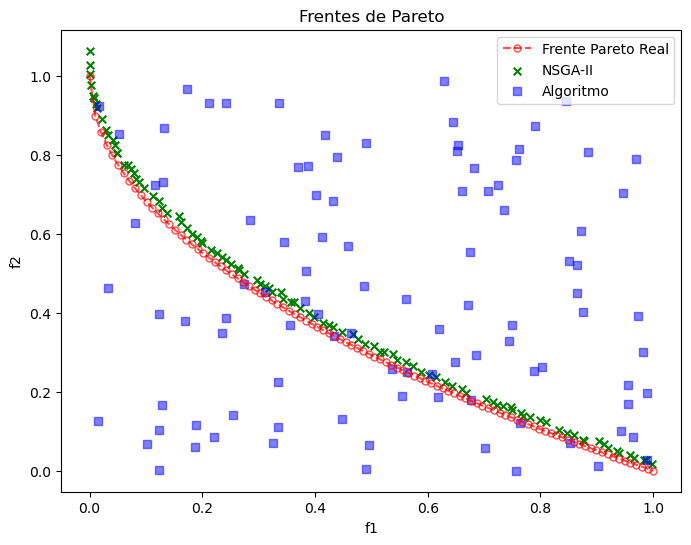

In [20]:
problem = get_problem("zdt1")
algorithm = NSGA2(pop_size=100)
nsga2_pareto = minimize(problem, algorithm, ('n_gen', 100), verbose=False)

# Genera un frente de pareto aleatorio
def random_pareto_front(num_points=100):
    f1 = np.random.uniform(0, 1, num_points)
    f2 = np.random.uniform(0, 1, num_points)
    return np.column_stack([f1, f2])

# Función para graficar los frentes de Pareto
def plot_pareto_example(problem, nsga2_pareto, alg_pareto):

    nsga2_f1, nsga2_f2 = nsga2_pareto.F[:, 0], nsga2_pareto.F[:, 1]

    plt.figure(figsize=(8, 6))

    # Frente de Pareto real de ZDT1 (rojo, puntos huecos)
    plt.plot(problem.pareto_front()[:, 0], problem.pareto_front()[:, 1], 
             color="red", label="Frente Pareto Real", linestyle="--", marker='o', markersize=5, alpha=0.7, markerfacecolor='none')

    # Frente de Pareto de NSGA-II (verde, puntos sólidos)
    plt.scatter(nsga2_f1, nsga2_f2, color="green", label="NSGA-II", s=30, marker='x', edgecolor="black")

    # Frente de Pareto del algoritmo implementado (azul, puntos con opacidad)
    plt.scatter(alg_pareto[:, 0], alg_pareto[:, 1], color="blue", label="Algoritmo", alpha=0.5, marker='s')

    plt.xlabel("f1")
    plt.ylabel("f2")
    plt.title("Frentes de Pareto")
    plt.legend()
    plt.show()

alg_pareto = random_pareto_front()
plot_pareto_example(problem, nsga2_pareto, alg_pareto)

---

In [21]:
from pymoo.indicators.hv import Hypervolume
import numpy as np


def calculate_metrics(front, ref_point):
    """ Calcula las métricas: hipervolumen, dispersión (SPR) y espaciado (SPA). """
    metricHV = Hypervolume(ref_point)
    
    hv = metricHV.do(front)

    # Dispersión: Diagonal de la hipercaja que contiene el frente
    min_values = np.min(front, axis=0)
    max_values = np.max(front, axis=0)
    spr = np.linalg.norm(max_values - min_values)

    # Espaciado: Distancia promedio entre puntos del frente
    d = np.linalg.norm(front[:, None, :] - front[None, :, :], axis=-1)  
    spa = np.mean(np.min(d + np.diag(np.inf * np.ones(len(d))), axis=1))  
    return hv, spr, spa

---

### **Algoritmo**

In [22]:
import random

def fitness_zdt1(individual):
    """ Función de fitness para ZDT1 """
    x = individual[0]
    f1 = x 
    g = 1 + 9 * (sum(individual[1:]) / (len(individual) - 1)) 
    f2 = g * (1 - (f1 / g) ** 0.5)
    
    return [f1, f2]


def dominance_rank(individual, population):
    """ Calcula el rango de dominancia de Pareto de un individuo en la población.
        - Menor rango significa que está en un frente de Pareto más alto (más óptimo) """
    dominated_count = 0
    for other in population:
        if dominates(individual, other):
            dominated_count += 1

    return dominated_count


def dominates(individual_1, individual_2):
    """
    Determina si el individuo 1 domina al individuo 2.
    Se dice que un individuo A domina a B si:
    - A es mejor o igual que B en todos los objetivos
    - A es estrictamente mejor que B en al menos un objetivo
    """
    f1_1, f2_1 = fitness_zdt1(individual_1)
    f1_2, f2_2 = fitness_zdt1(individual_2)

    # Un individuo domina a otro si es mejor o igual en todos los objetivos y mejor en al menos uno
    return (f1_1 <= f1_2 and f2_1 <= f2_2) and (f1_1 < f1_2 or f2_1 < f2_2)


def sort_pop(pop, fitness):
    """ Ordena la población según su rango de dominancia de Pareto (de menor a mayor rango) """

    pop_with_rank = [(indiv, dominance_rank(indiv, pop)) for indiv in pop]
    sorted_pop = sorted(pop_with_rank, key=lambda x: x[1])

    return [indiv for indiv, _ in sorted_pop], [fitness(indiv) for indiv, _ in sorted_pop]


def create_zdt1_population(N=100):
    """ Crea una población para ZDT1. Cada individuo tiene un valor en el rango [0, 1] """
    return [[random.uniform(0, 1) for _ in range(30)] for _ in range(N)]  # 30 variables


def local_search_zdt1(individual, step_size=0.1, max_iterations=1):
    """
    Local search for ZDT1.
    :param individual: List or array of decision variables (x1, x2, ..., xn).
    :param step_size: Maximum step size for perturbation.
    :param max_iterations: Number of iterations for the local search.
    :return: Modified individual.
    """
    n = len(individual)
    current_solution = np.array(individual)
    
    for _ in range(max_iterations):
        # Generate a random direction for perturbation
        direction = np.random.uniform(-1, 1, size=n)
        direction = direction / np.linalg.norm(direction)  # Normalize the direction
        
        # Perturb the solution
        new_solution = current_solution + step_size * direction
        
        # Ensure the solution stays within bounds [0, 1]
        new_solution = np.clip(new_solution, 0, 1)
        
        # Evaluate objectives for current and new solutions
        f1_current = current_solution[0]
        g_current = 1 + 9 * np.mean(current_solution[1:])
        f2_current = g_current * (1 - np.sqrt(f1_current / g_current))
        
        f1_new = new_solution[0]
        g_new = 1 + 9 * np.mean(new_solution[1:])
        f2_new = g_new * (1 - np.sqrt(f1_new / g_new))
        
        # Compare solutions (Pareto dominance)
        if (f1_new <= f1_current and f2_new <= f2_current) and \
           (f1_new < f1_current or f2_new < f2_current):
            current_solution = new_solution  # Accept the new solution
    
    return current_solution.tolist()

In [23]:
def select(pop, T):
    # Selección por torneo basado en la dominancia de Pareto
    tournament = random.sample(pop, T)

    # Ordena los individuos según la dominancia de Pareto (pasando la población completa a la función)
    tournament_sorted = sorted(tournament, key=lambda ind: dominance_rank(ind, pop), reverse=False)

    return tournament_sorted[0]  # El mejor individuo (con menor índice de dominancia)


def crossover(ind1, ind2, pcross):
    if random.random() > pcross:
        return ind1.copy(), ind2.copy()

    beta = random.uniform(0, 1)
    child1 = [beta * ind1[i] + (1 - beta) * ind2[i] for i in range(len(ind1))]
    child2 = [(1 - beta) * ind1[i] + beta * ind2[i] for i in range(len(ind1))]

    return child1, child2


def mutate(ind, pmut):
    if random.random() < pmut:
        index = random.randint(0, len(ind) - 1)
        ind[index] = random.uniform(0, 1)  # Mutación aleatoria
    return ind


In [24]:
""" Ejecuta la evolución generacional de la población utilizando selección, crossover, mutación y búsqueda local """
def evolve(pop, fitness, pmut=0.1, neval=3500, T=2, trace=0, pcross=0.7, elitism=False, 
           step_size=0.1, local_search_prob=0.1, ls_function=None):
    
    evaluaciones = 0  # Se elimina el uso de 'global'
    pop, _ = sort_pop(pop, fitness)  # Ordenar la población por el fitness al principio

    while evaluaciones < neval:
        new_poblacion = []

        if elitism:
            best_indv = pop[0]  # Mantener el mejor individuo (elitismo)
            new_poblacion.append(best_indv.copy())

        # Operaciones de selección, crossover y mutación
        while len(new_poblacion) < len(pop):
            parent_1 = select(pop, T)
            parent_2 = select(pop, T)

            # Operación de crossover
            child_1, child_2 = crossover(parent_1, parent_2, pcross)

            # Operación de mutación
            child_1 = mutate(child_1, pmut)
            child_2 = mutate(child_2, pmut)

            # Búsqueda local en los hijos
            if ls_function and random.random() < local_search_prob:
                child_1 = ls_function(child_1, step_size)
            if ls_function and random.random() < local_search_prob:
                child_2 = ls_function(child_2, step_size)

            # Agregar los nuevos hijos a la nueva población, asegurando que no crezca demasiado
            new_poblacion.append(child_1)
            if len(new_poblacion) < len(pop):  # Asegurarse de no exceder el tamaño de la población
                new_poblacion.append(child_2)

            # Actualización del contador de evaluaciones
            evaluaciones += 2  # Dos evaluaciones por cada par de hijos creados

            # Verificar el límite de evaluaciones
            if evaluaciones >= neval:
                break

        # Ordenar la nueva población por el fitness
        pop, fitness_values = sort_pop(new_poblacion[:len(pop)], fitness)

        # Mostrar el progreso cada cierto número de evaluaciones
        if trace > 0 and evaluaciones % trace == 0:
            print(f"Evaluaciones: {evaluaciones}, Mejor fitness: {fitness_values[0]}")

        # Si ya alcanzamos el límite de evaluaciones, salimos
        if evaluaciones >= neval:
            break

    print(f"Evaluaciones: {evaluaciones}, Mejor fitness: {fitness_values[0]}")
    return pop

### **Evaluación**

In [26]:
# Función para graficar los frentes de Pareto
def plot_pareto(problem, nsga2_pareto, pop):

    nsga2_f1, nsga2_f2 = nsga2_pareto.F[:, 0], nsga2_pareto.F[:, 1]
    plt.figure(figsize=(8, 6))

    # Frente de Pareto real de ZDT1 (rojo, puntos huecos)
    plt.plot(problem.pareto_front()[:, 0], problem.pareto_front()[:, 1], 
             color="red", label="Frente Pareto Real", linestyle="--", marker='o', markersize=5, alpha=0.7, markerfacecolor='none')

    # Frente de Pareto de NSGA-II (verde, puntos sólidos)
    plt.scatter(nsga2_f1, nsga2_f2, color="green", label="NSGA-II", s=30, marker='x', edgecolor="black")

    # Frente de Pareto del algoritmo implementado (azul, puntos con opacidad)
    f1, f2 = zip(*[fitness_zdt1(ind) for ind in pop])
    plt.scatter(f1, f2, color="blue", label="Algoritmo", alpha=0.5, marker='s')

    plt.xlabel("f1")
    plt.ylabel("f2")
    plt.title("Frentes de Pareto")
    plt.legend()
    plt.show()


Evaluaciones: 10000, Mejor fitness: [0.37003866063579766, 5.443908140016788]


C:\Users\34627\AppData\Local\Temp\ipykernel_16616\2248681565.py:12: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(nsga2_f1, nsga2_f2, color="green", label="NSGA-II", s=30, marker='x', edgecolor="black")


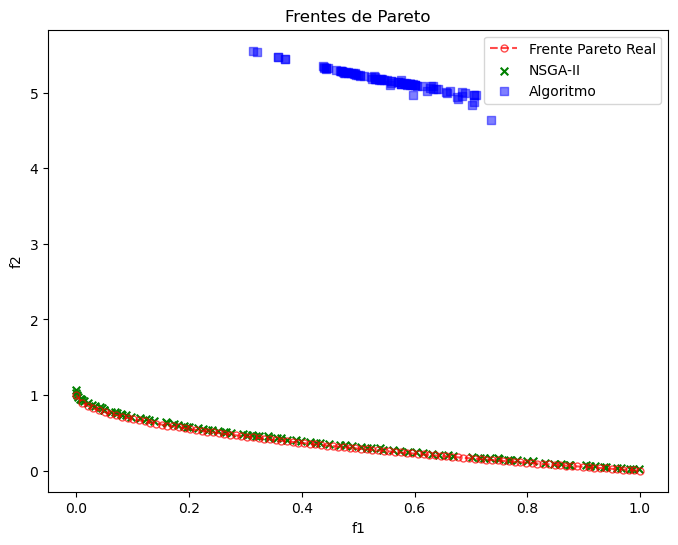

In [ ]:
### Inicializar el problema ZDT1 y obtener pareto de NSGA2 para comparar ###
problem = get_problem("zdt1")
algorithm = NSGA2(pop_size=100)
ref_point = [1.1, 1.1]

if nsga2_pareto is None: nsga2_pareto = minimize(problem, algorithm, ('n_gen', 100), verbose=False)

### población inicial para ZDT1 ###
population = create_zdt1_population(N=100)

##############################
### Llamada Algoritmo ###
##############################

result_population = evolve(population, fitness=fitness_zdt1, pmut=0.1, neval=10000, T=2, pcross=0.7, elitism=False, step_size=0.1, local_search_prob=0.1, ls_function=local_search_zdt1)

### Grafica ###
plot_pareto(problem, nsga2_pareto, result_population)

---

In [ ]:
'''
    Ejecuta múltiples experimentos dado un problema y un algoritmo de optimización multi-objetivo. Se le pasa el punto de referencia del hipervolumen,
    el número de experimentos y el número de generaciones. El criterio de selección del mejor frente de pareto se puede modificar. Por defecto, se hace según 
    el hipervolumen. 

    @return
        - best_individual_ frnete_pareto [[distance1, time1], [distance2, time2], ...], 
        - metrics_summary: resumen de metricas de los 10 experimentos
        - ref_point: punto de referencia sobre el hipervolumen. Con este punto de referencia se calcula el hipervolumen del frente de pareto del algoritmo NSGA2 a superar

'''
def multiple_experiments_with_metrics(problem, fitness_function, ref_point, num_experiments=10, 
                                      pop_size=100, neval=10000, pmut=0.1, pcross=0.7, 
                                      elitism=False, step_size=0.1, local_search_prob=0.1):
    
    best_individual = None
    # best_hypervolume = -float('inf')  # el signo negativo para maximizar el hipervolumen
    best_spr = float('inf')
    metrics_summary = []

    for i in range(num_experiments):   
        
        population = create_zdt1_population(N=100)

        population = evolve(
            population,
            fitness=fitness_function,
            pmut=pmut,
            pcross=pcross,
            neval=neval,
            T=2,
            elitism=elitism,
            step_size=step_size,
            local_search_prob=local_search_prob,
            ls_function=local_search_zdt1  # Reemplaza con tu función de búsqueda local si es distinta
        )


        # Evaluar el frente de Pareto de la población final
        fitness_values = np.array([fitness_function(ind) for ind in population])
        front = fitness_values  # Asumimos que el frente se obtiene directamente de las evaluaciones

        if front is None or len(front) == 0:
            continue

        if i == 0:
            # El ref_point, tras el primer experimento, es el máximo del primer frente incrementado por 1.3
            ref_point = np.max(front, axis=0) * 1.3  

        # Calcular métricas
        hv, spr, spa = calculate_metrics(front, ref_point)
        metrics_summary.append((hv, spr, spa))

        print(f"Ejecución {i+1}: Hipervolumen: {hv:.4f}, Dispersión (SPR): {spr:.4f}, Espaciado (SPA): {spa:.4f}")

        # Seleccionar el mejor frente según el criterio (hipervolumen en este caso)
        if spr < best_spr:
            best_spr = spr
            best_individual = front

    # Promedios y desviaciones estándar de las métricas
    metrics_summary = np.array(metrics_summary)
    mean_metrics = np.mean(metrics_summary, axis=0)
    std_metrics = np.std(metrics_summary, axis=0)

    print("\n--- Resumen de Métricas ---")
    print(f"Promedio de Hipervolumen: {mean_metrics[0]:.4f} ± {std_metrics[0]:.4f}")
    print(f"Promedio de Dispersión (SPR): {mean_metrics[1]:.4f} ± {std_metrics[1]:.4f}")
    print(f"Promedio de Espaciado (SPA): {mean_metrics[2]:.4f} ± {std_metrics[2]:.4f}")

    return best_individual, metrics_summary, ref_point

C:\Users\34627\AppData\Local\Temp\ipykernel_16616\2248681565.py:12: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(nsga2_f1, nsga2_f2, color="green", label="NSGA-II", s=30, marker='x', edgecolor="black")


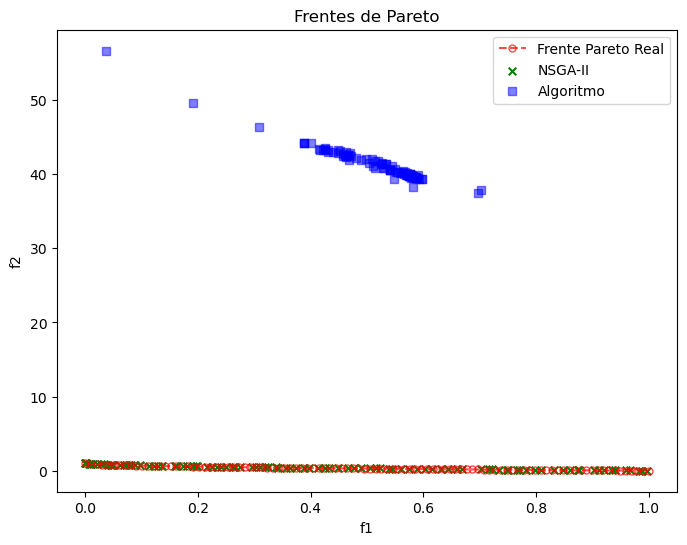

In [ ]:
### Inicializar el problema ZDT1 y obtener pareto de NSGA2 para comparar ###
problem = get_problem("zdt1")
algorithm = NSGA2(pop_size=100)
ref_point = [1.1, 1.1]

if nsga2_pareto is None: nsga2_pareto = minimize(problem, algorithm, ('n_gen', 100), verbose=False)


best_front, metrics, ref_point = multiple_experiments_with_metrics(
    problem=problem,
    fitness_function=fitness_zdt1,
    ref_point=[1.1, 1.1],
    num_experiments=10,
    pop_size=100,
    neval=10000,  # Número total de evaluaciones
    pmut=0.1,
    pcross=0.7
)

from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

# Función para calcular el frente de Pareto
def get_pareto_front(population, fitness_function):
    fitness_values = np.array([fitness_function(ind) for ind in population])
    nds = NonDominatedSorting().do(fitness_values)
    pareto_front = fitness_values[nds == 0]
    return pareto_front

# Obtener el frente de Pareto de best_front
pareto_front = get_pareto_front(best_front, fitness_zdt1)

# Cálculo de métricas
hv, spr, spa = calculate_metrics(pareto_front, ref_point)
hv_obj, spr_obj, spa_obj = calculate_metrics(nsga2_pareto.F, ref_point)

# Preparar resultados para comparar
data = {'Hipervolumen': [hv, hv_obj], 'Dispersión (SPR)': [spr, spr_obj], 'Espaciado (SPA)': [spa, spa_obj]}
df = pd.DataFrame(data, index=['Nuestro Algoritmo', 'NSGA2 a Batir'])

print(f"\n{df}")

# Gráfica del frente de Pareto
sorted_res = pareto_front[np.argsort(pareto_front[:, 0])]
sorted_res2 = nsga2_pareto.F[np.argsort(nsga2_pareto.F[:, 0])]

plt.figure(figsize=(10, 6))

# Líneas conectando los puntos
plt.plot(sorted_res[:, 0], sorted_res[:, 1], color="blue", alpha=0.7, label="Nuestro Algoritmo")
plt.plot(sorted_res2[:, 0], sorted_res2[:, 1], color="orange", alpha=0.7, label="NSGA2 a Batir")

# Puntos del frente de Pareto
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], s=30, facecolors='none', edgecolors='blue', label="Puntos Nuestro Algoritmo")
plt.scatter(nsga2_pareto.F[:, 0], nsga2_pareto.F[:, 1], s=30, facecolors='none', edgecolors='orange', label="Puntos NSGA2 a Batir")

# Etiquetas y leyenda
plt.xlabel('f1', fontsize=12)
plt.ylabel('f2', fontsize=12)
plt.legend(fontsize=12)

plt.title("Comparación de Frentes de Pareto: Nuestro Algoritmo vs NSGA2", fontsize=14)
plt.show()


# plot_pareto(problem, nsga2_pareto, sorted_res)